In [ ]:
from retrieval_utils import list_images, IMG_DIR, MANIFEST
import pandas as pd

paths = list_images(IMG_DIR)   # يتأكد وجود صور محلياً
assert len(paths) > 0, "ضع صورك داخل data/images_cache/ ثم أعد التشغيل."
pd.DataFrame({"image_path":[str(p.relative_to(IMG_DIR)) for p in paths]}).to_csv(MANIFEST, index=False)
MANIFEST, len(paths)


In [ ]:
import pandas as pd
from retrieval_utils import build_or_load_embeds, IMG_DIR

paths = [IMG_DIR / p for p in pd.read_csv("gallery_paths.csv")["image_path"]]

emb_b32 = build_or_load_embeds("ViT-B-32","openai", paths, "data/embeddings_b32.npy", bs=64)
emb_l14 = build_or_load_embeds("ViT-L-14","openai", paths, "data/embeddings_l14.npy", bs=32)

emb_b32.shape, emb_l14.shape


In [ ]:
import numpy as np, pandas as pd
from retrieval_utils import load_model, encode_text, show_grid_local

emb_b32 = np.load("data/embeddings_b32.npy")
emb_l14 = np.load("data/embeddings_l14.npy")
meta    = pd.read_csv("gallery_paths.csv")

m_b32, _, tok_b32, device = load_model("ViT-B-32","openai")
m_l14, _, tok_l14, _      = load_model("ViT-L-14","openai")

device, emb_b32.shape, emb_l14.shape, len(meta)


In [ ]:
query = "a high-quality close-up photo of a red sports car at night"

q_b32 = encode_text(query, m_b32, tok_b32, device)
q_l14 = encode_text(query, m_l14, tok_l14, device)

df_b32 = meta.copy(); df_b32["score"] = emb_b32 @ q_b32
df_l14 = meta.copy(); df_l14["score"] = emb_l14 @ q_l14

top12_l14 = df_l14.sort_values("score", ascending=False).head(12)
show_grid_local(top12_l14, "Top matches (L/14)")
top12_l14.head(12)


In [ ]:
tau = 0.30
rejected = df_l14[df_l14["score"] < tau].sort_values("score").head(24)
show_grid_local(rejected, f"Rejected (score < {tau})")


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.hist(df_b32["score"], bins=40, alpha=0.6, label="B/32")
plt.hist(df_l14["score"], bins=40, alpha=0.6, label="L/14")
plt.xlabel("Cosine score"); plt.ylabel("Count"); plt.legend(); plt.title("Score Distribution"); plt.show()

merged = df_b32[["image_path","score"]].merge(
    df_l14[["image_path","score"]], on="image_path", suffixes=("_B32","_L14")
)
plt.figure(figsize=(5,5))
plt.scatter(merged["score_B32"], merged["score_L14"], s=8)
lims = [merged[["score_B32","score_L14"]].min().min(), merged[["score_B32","score_L14"]].max().max()]
plt.plot(lims, lims)
plt.xlabel("B/32"); plt.ylabel("L/14"); plt.title("Per-image score comparison"); plt.show()


In [20]:
from pathlib import Path
import numpy as np, pandas as pd, torch, torch.nn.functional as F
from PIL import Image
import open_clip

device   = "cuda" if torch.cuda.is_available() else "cpu"
IMG_DIR  = Path("images_cache"); IMG_DIR.mkdir(exist_ok=True)
MANIFEST = Path("gallery_paths.csv")  # لائحة الصور


In [21]:
import hashlib, requests
from io import BytesIO

def cached_path_from_url(url: str) -> Path:
    name = hashlib.md5(url.encode()).hexdigest() + ".jpg"
    p = IMG_DIR / name
    if not p.exists():
        r = requests.get(url, timeout=20); r.raise_for_status()
        Image.open(BytesIO(r.content)).convert("RGB").save(p, "JPEG", quality=95)
    return p


In [22]:
def list_images(img_dir: Path):
    exts = {".jpg",".jpeg",".png",".webp",".bmp"}
    return sorted([p for p in img_dir.rglob("*") if p.suffix.lower() in exts])

def load_model(model_id="ViT-B-32", pretrained="openai"):
    m, preprocess, _ = open_clip.create_model_and_transforms(model_id, pretrained=pretrained)
    return m.to(device).eval(), preprocess, open_clip.get_tokenizer(model_id)

@torch.no_grad()
def encode_images(paths, model, preprocess, bs=64):
    feats = []
    for i in range(0, len(paths), bs):
        batch = [preprocess(Image.open(p).convert("RGB")) for p in paths[i:i+bs]]
        x = torch.stack(batch).to(device)
        z = model.encode_image(x)
        z = F.normalize(z, dim=-1).cpu().float()
        feats.append(z)
    return torch.cat(feats, dim=0).numpy()

def build_or_load_embeds(model_id, pretrained, paths, out_path, bs=64):
    out = Path(out_path)
    if out.exists():
        return np.load(out)
    model, preprocess, _ = load_model(model_id, pretrained)
    emb = encode_images(paths, model, preprocess, bs=bs)
    np.save(out, emb)
    return emb


In [23]:
# 1) جهّز قائمة الصور
paths = list_images(IMG_DIR)
pd.DataFrame({"image_path":[str(p.relative_to(IMG_DIR)) for p in paths]}).to_csv(MANIFEST, index=False)

# 2) ابني/حمّل embeddings للموديلين
emb_b32 = build_or_load_embeds("ViT-B-32","openai", paths, "embeddings_b32.npy", bs=64)
emb_l14 = build_or_load_embeds("ViT-L-14","openai", paths, "embeddings_l14.npy", bs=32)  # لو GPU أضعف قلّل bs


In [24]:
def encode_text(query, model, tokenizer):
    with torch.no_grad():
        tok = tokenizer([query]).to(device)
        z = model.encode_text(tok)
        return F.normalize(z, dim=-1).cpu().numpy()[0]

# حمّل الموديلات النصية مرة (بدون إعادة بناء embeddings)
m_b32, _, tok_b32 = load_model("ViT-B-32","openai")
m_l14, _, tok_l14 = load_model("ViT-L-14","openai")


c:\Users\lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\open_clip\factory.py:450: UserWarning: QuickGELU mismatch between final model config (quick_gelu=False) and pretrained tag 'openai' (quick_gelu=True).
  warnings.warn(


In [25]:
query = "a high-quality close-up photo of a red sports car at night"

# B/32
q_b32 = encode_text(query, m_b32, tok_b32)
scores_b32 = emb_b32 @ q_b32
df_b32 = pd.read_csv(MANIFEST); df_b32["score"] = scores_b32
df_b32.sort_values("score", ascending=False).head(20)

# L/14
q_l14 = encode_text(query, m_l14, tok_l14)
scores_l14 = emb_l14 @ q_l14
df_l14 = pd.read_csv(MANIFEST); df_l14["score"] = scores_l14
df_l14.sort_values("score", ascending=False).head(20)


image_path     score
80                        DqYw4KMZYOE.jpg  0.208144
129                       oZzoDW61aoM.jpg  0.179959
134                       pO16AqrOa80.jpg  0.178927
78   de1b2153a73f5f32fce3d356d8a02f76.jpg  0.178817
97                        GfuxOPaitSs.jpg  0.176251
36   7afcb48a1714395e938613b2f0b4dbec.jpg  0.174863
163                       VvYzZeTAqm4.jpg  0.172944
186                       zlGFO4rS4Yo.jpg  0.170463
156                       uC21aXJ7yQs.jpg  0.168925
168                       x7EwXNcMAZ4.jpg  0.167700
13   451a77417d413940c1f79159e377fee9.jpg  0.167421
158                       UhlE4FBAXgo.jpg  0.167242
76   dab4042b2014689658f40b637787e131.jpg  0.164002
108                       IgRQVZq7E3M.jpg  0.162183
84   ea1cbaec6b02993876e947aa690b88fb.jpg  0.160672
64                        BeD3vjQ8SI0.jpg  0.160118
92   ff39898432aac70d7bf9818deae663e3.jpg  0.158735
46   8f8f2c8a53e1377ffe4f2f42eb8f35d6.jpg  0.156467
159                       UjbaffVRsYc.jpg  0.154322
182                       YWhRvW7KRJY.jpg  0.153417

In [14]:
from pathlib import Path
import os, pandas as pd, faiss, numpy as np

# حدّد مجلد مشروعك (المكان اللي فيه photos.csv و artifacts/)
PROJECT_ROOT = Path(r"\\wsl.localhost\Ubuntu\home\othman\code\Othman-02\swipe")

# اختياري: غيّر مجلد العمل الحالي للمشروع
os.chdir(PROJECT_ROOT)

# عرّف المسارات المركزية
ART_DIR  = PROJECT_ROOT / "artifacts"
DATA_DIR = PROJECT_ROOT  # لو photos.csv في نفس جذر المشروع

print("CWD:", Path.cwd())
print("ART_DIR exists:", ART_DIR.exists())


CWD: \\wsl.localhost\Ubuntu\home\othman\code\Othman-02\swipe
ART_DIR exists: True


In [15]:
# اقرأ البيانات
df_photos = pd.read_csv(DATA_DIR / "photos.csv", low_memory=False)

# حمّل الفهرس والميتا
index    = faiss.read_index(str(ART_DIR / "faiss_ip.index"))
ids_only = pd.read_csv(ART_DIR / "photo_meta_ids.csv").reset_index(drop=True)
ids_only["faiss_pos"] = range(len(ids_only))

# اربط مع df_photos وحافظ على الترتيب 1:1 مع الفهرس
meta = ids_only.merge(
    df_photos[["photo_id","photo_image_url"]].assign(
        photo_id=df_photos["photo_id"].astype(str)
    ),
    on="photo_id", how="left"
).sort_values("faiss_pos").reset_index(drop=True)

print("Index size:", index.ntotal, "| Meta rows:", len(meta))
assert index.ntotal == len(meta), "Mismatch between FAISS index and meta length!"


Index size: 999 | Meta rows: 999


In [16]:
%pip install -U torch torchvision torchaudio \
  "transformers==4.43.3" "sentence-transformers==3.0.1" \
  faiss-cpu accelerate safetensors \
  requests tqdm matplotlib pillow numpy


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [17]:
import pandas as pd

df_photos = pd.read_csv("photos.csv", low_memory=False)
assert {"photo_id","photo_image_url"} <= set(df_photos.columns)
df_photos.head(2)


photo_id                                photo_url  \
0  XMyPniM9LF0  https://unsplash.com/photos/XMyPniM9LF0   
1  rDLBArZUl1c  https://unsplash.com/photos/rDLBArZUl1c   

                                     photo_image_url  \
0  https://images.unsplash.com/uploads/1411949294...   
1  https://images.unsplash.com/photo-141633941111...   

           photo_submitted_at photo_featured  photo_width  photo_height  \
0  2014-09-29 00:08:38.594364              t         4272          2848   
1   2014-11-18 19:36:57.08945              t         3000          4000   

   photo_aspect_ratio          photo_description photographer_username  ...  \
0                1.50   Woman exploring a forest     michellespencer77  ...   
1                0.75  Succulents in a terrarium                ugmonk  ...   

  photo_location_country photo_location_city stats_views stats_downloads  \
0                    NaN                 NaN     2375421            6967   
1                    NaN                 NaN    13784815           82141   

                              ai_description ai_primary_landmark_name  \
0      woman walking in the middle of forest                      NaN   
1  succulent plants in clear glass terrarium                      NaN   

  ai_primary_landmark_latitude ai_primary_landmark_longitude  \
0                          NaN                           NaN   
1                          NaN                           NaN   

  ai_primary_landmark_confidence                     blur_hash  
0                            NaN  L56bVcRRIWMh.gVunlS4SMbsRRxr  
1                            NaN  LvI$4txu%2s:_4t6WUj]xat7RPoe  

[2 rows x 31 columns]

In [18]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from urllib.parse import urlparse, urlunparse, parse_qs, urlencode
import requests, numpy as np, os
from PIL import Image, ImageFile
from io import BytesIO
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
import faiss, torch

ImageFile.LOAD_TRUNCATED_IMAGES = True  # يسمح بفتح صور مقطوعة

# إعدادات
N_SAMPLE    = 1000      # كبداية. لاحقًا: len(df_photos)
MAX_WORKERS = 16        # جرّب 8–16 إذا الشبكة أبطأ
BATCH_URLS  = 128
RESIZE_W    = 512
TIMEOUT     = 12
ART_DIR     = "artifacts"
os.makedirs(ART_DIR, exist_ok=True)

urls_all = df_photos["photo_image_url"].tolist()[:N_SAMPLE]
ids_all  = df_photos["photo_id"].astype(str).tolist()[:N_SAMPLE]

# نموذج CLIP عبر sentence-transformers
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = SentenceTransformer("clip-ViT-B-32", device=DEVICE)

# جلسة Requests مع إعادة المحاولة
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
session = requests.Session()
session.headers.update({
    "User-Agent": "clip-fast/1.0",
    "Accept": "image/avif,image/webp,image/*,*/*;q=0.8",
})
adapter = HTTPAdapter(pool_connections=MAX_WORKERS, pool_maxsize=MAX_WORKERS,
                      max_retries=Retry(total=3, backoff_factor=0.25,
                                        status_forcelist=[429,500,502,503,504]))
session.mount("http://", adapter); session.mount("https://", adapter)

def clamp_unsplash(url, w=RESIZE_W, auto=True):
    u = urlparse(url)
    q = parse_qs(u.query)
    q["w"] = [str(w)]
    if auto: q["auto"] = ["format"]
    return urlunparse(u._replace(query=urlencode(q, doseq=True)))

def fetch_img(url):
    try:
        r = session.get(clamp_unsplash(url), timeout=TIMEOUT)
        r.raise_for_status()
        return Image.open(BytesIO(r.content)).convert("RGB")
    except Exception:
        return None

def fetch_batch(urls, ids):
    items = []
    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as ex:
        fut = {ex.submit(fetch_img, u): i for i,u in enumerate(urls)}
        for f in as_completed(fut):
            i = fut[f]; img = f.result()
            if img is not None:
                items.append((i, img, ids[i]))
    items.sort(key=lambda x: x[0])
    imgs  = [im  for _, im,  _ in items]
    k_ids = [id_ for _,  _, id_ in items]
    return imgs, k_ids


In [19]:
import numpy as np, pandas as pd, faiss

all_embs, kept_ids = [], []
pbar = tqdm(range(0, len(urls_all), BATCH_URLS), desc="Downloading+Encoding", unit="batch")
for s in pbar:
    bu = urls_all[s:s+BATCH_URLS]
    bi = ids_all[s:s+BATCH_URLS]
    imgs, k_ids = fetch_batch(bu, bi)
    pbar.set_postfix_str(f"ok:{len(k_ids)}/{len(bu)}")
    if not imgs:
        continue
    vecs = model.encode(imgs, normalize_embeddings=True,
                    convert_to_tensor=False).astype("float32")
    all_embs.append(vecs); kept_ids.extend(k_ids)

if not all_embs:
    raise RuntimeError("No images were successfully downloaded/encoded. Try lower MAX_WORKERS or higher TIMEOUT.")

image_emb = np.vstack(all_embs)
np.save(f"{ART_DIR}/image_emb_fp16.npy", image_emb.astype("float16"))
pd.DataFrame({"photo_id": kept_ids}).to_csv(f"{ART_DIR}/photo_meta_ids.csv", index=False)

index = faiss.IndexFlatIP(image_emb.shape[1])
index.add(image_emb)
faiss.write_index(index, f"{ART_DIR}/faiss_ip.index")

print("✅ Done:", image_emb.shape)


Downloading+Encoding: 100%|██████████| 8/8 [02:18<00:00, 17.30s/batch, ok:104/104]

✅ Done: (999, 512)


In [6]:
import faiss, pandas as pd, numpy as np

index = faiss.read_index(f"{ART_DIR}/faiss_ip.index")
ids_only = pd.read_csv(f"{ART_DIR}/photo_meta_ids.csv").reset_index(drop=True)
ids_only["faiss_pos"] = range(len(ids_only))

meta = ids_only.merge(
    df_photos[["photo_id","photo_image_url"]].assign(photo_id=df_photos["photo_id"].astype(str)),
    on="photo_id", how="left"
).sort_values("faiss_pos").reset_index(drop=True)

print("Index size:", index.ntotal, "| Meta rows:", len(meta))
assert index.ntotal == len(meta), "Mismatch between FAISS index and meta length!"


ModuleNotFoundError: No module named 'faiss'

In [ ]:
import numpy as np, requests, matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO

def _fetch(url, timeout=10):
    r = requests.get(url, timeout=timeout); r.raise_for_status()
    return Image.open(BytesIO(r.content)).convert("RGB")

def show_grid(df, title=None, max_cols=5):
    n=len(df); cols=min(n,max_cols); rows=(n+cols-1)//cols
    plt.figure(figsize=(3.2*cols,3.2*rows))
    for i,(_,row) in enumerate(df.iterrows(),1):
        plt.subplot(rows, cols, i)
        plt.imshow(_fetch(row["photo_image_url"])); plt.axis("off")
        plt.title(f"{row.get('score',0):.2f}")
    if title: plt.suptitle(title, y=0.99)
    plt.tight_layout(); plt.show()

def _safe_take(df, idxs):
    idxs = [int(i) for i in idxs if 0 <= int(i) < len(df)]
    return df.iloc[idxs].copy()

def search_by_text(query, k=12):
    # لا تستخدم texts= ، مرّر القائمة مباشرة
    q = model.encode([query], normalize_embeddings=True,
                     convert_to_tensor=False).astype("float32")
    D, I = index.search(q, k)
    out = _safe_take(meta, I[0])
    out["score"] = D[0][:len(out)]
    return out.reset_index(drop=True)

def search_by_image_url(url, k=12):
    img = _fetch(url)
    # لا تستخدم images= ، مرّر القائمة مباشرة
    q = model.encode([img], normalize_embeddings=True,
                     convert_to_tensor=False).astype("float32")
    D, I = index.search(q, k)
    out = _safe_take(meta, I[0])
    out["score"] = D[0][:len(out)]
    return out.reset_index(drop=True)


In [7]:
res1 = search_by_text("sunset beach", k=8)
show_grid(res1, "Text: sunset beach")

seed = meta.sample(1, random_state=7).iloc[0]["photo_image_url"]
res2  = search_by_image_url(seed, k=8)
show_grid(res2, "Similar to seed")
print("Seed URL:", seed)


NameError: name 'search_by_text' is not defined

In [ ]:
import numpy as np, pandas as pd, faiss

# حمّل المصفوفة والفهرس والميتا
EMB  = np.load("artifacts/image_emb_fp16.npy").astype("float32")  # (N,512)
index = faiss.read_index("artifacts/faiss_ip.index")
meta  = pd.read_csv("artifacts/photo_meta_ids.csv").reset_index(drop=True)
# اربطها بـ df_photos للحصول على الروابط
meta = meta.merge(df_photos[["photo_id","photo_image_url"]].assign(photo_id=df_photos["photo_id"].astype(str)),
                  on="photo_id", how="left")

# خريطة سريعة من photo_id → موضعه في المصفوفة
id2pos = dict(zip(meta["photo_id"], meta.index))

def emb_by_pos(i: int) -> np.ndarray:
    return EMB[i]  # شكلها (512,)

def emb_by_photo_id(pid: str) -> np.ndarray:
    return EMB[id2pos[str(pid)]]

def emb_of_text(text: str) -> np.ndarray:
    v = model.encode([text], normalize_embeddings=True, convert_to_tensor=False).astype("float32")[0]
    return v  # (512,)

def emb_of_image_url(url: str) -> np.ndarray:
    img = _fetch(url)
    v = model.encode([img], normalize_embeddings=True, convert_to_tensor=False).astype("float32")[0]
    return v


In [ ]:
# قارن نص مع صورة مثلاً:
v_text = emb_of_text("cat")
v_img  = emb_of_image_url(meta.iloc[0]["photo_image_url"])
cosine = float(np.dot(v_text, v_img))    # بين -1 و 1
cosine


NameError: name 'emb_of_text' is not defined

In [2]:
v_new = emb_of_text("a close-up of a cat with blue eyes")
scores = EMB @ v_new                    # (N,)
topk   = np.argsort(-scores)[:12]       # أعلى 12
meta.iloc[topk].assign(score=scores[topk])


NameError: name 'emb_of_text' is not defined

In [3]:
# اصنع DataFrame للنتائج
hits = meta.iloc[topk].assign(score=scores[topk]).reset_index(drop=True)

# إن كان عندك show_grid سابقًا:
show_grid(hits, title="Top matches")

# أو استخدم نسخة خفيفة هنا:
import matplotlib.pyplot as plt, requests
from PIL import Image
from io import BytesIO

def show_grid_from_df(df, title=None, max_cols=5):
    n = len(df); cols = min(n, max_cols); rows = (n+cols-1)//cols
    plt.figure(figsize=(3.2*cols, 3.2*rows))
    for i,(_,row) in enumerate(df.iterrows(), 1):
        img = Image.open(BytesIO(requests.get(row["photo_image_url"], timeout=10).content)).convert("RGB")
        plt.subplot(rows, cols, i); plt.imshow(img); plt.axis("off")
        plt.title(f"{row.get('score',0):.2f}")
    if title: plt.suptitle(title, y=0.99)
    plt.tight_layout(); plt.show()

show_grid_from_df(hits, "Top matches")


NameError: name 'meta' is not defined

In [4]:
!pip install open-clip-torch

In [5]:
import open_clip

model, preprocess, _ = open_clip.create_model_and_transforms("ViT-L-14", pretrained="openai")
print("Model loaded successfully:", type(model))


/home/othman/swipe-sense/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/othman/swipe-sense/.venv/lib/python3.12/site-packages/open_clip/factory.py:450: UserWarning: QuickGELU mismatch between final model config (quick_gelu=False) and pretrained tag 'openai' (quick_gelu=True).
  warnings.warn(


Model loaded successfully: <class 'open_clip.model.CLIP'>


In [ ]:

import os, numpy as np, pandas as pd, torch, torch.nn.functional as F
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import open_clip

device = "cuda" if torch.cuda.is_available() else "cpu"
IMG_DIR = Path("images_cache")  # عدّلها لو مسارك مختلف
META_CSV = None                 # اختياري: حط مسار ميتاداتا لو عندك


In [36]:
def load_model(model_id="ViT-B-32", pretrained="openai"):
    model, preprocess, _ = open_clip.create_model_and_transforms(model_id, pretrained=pretrained)
    model = model.to(device).eval()
    tokenizer = open_clip.get_tokenizer(model_id)
    return model, preprocess, tokenizer

@torch.no_grad()
def encode_images(paths, model, preprocess, bs=32):
    feats = []
    for i in range(0, len(paths), bs):
        batch_paths = paths[i:i+bs]
        imgs = [preprocess(Image.open(p).convert("RGB")) for p in batch_paths]
        x = torch.stack(imgs).to(device)
        z = model.encode_image(x)
        z = F.normalize(z, dim=-1)
        feats.append(z.detach().cpu().float())
    return torch.cat(feats, dim=0).numpy()  # (N,D)

@torch.no_grad()
def encode_text(query, model, tokenizer):
    tok = tokenizer([query]).to(device)
    z = model.encode_text(tok)
    z = F.normalize(z, dim=-1)
    return z.detach().cpu().float().numpy()[0]  # (D,)

def list_images(img_dir: Path):
    exts = {".jpg",".jpeg",".png",".webp",".bmp"}
    return sorted([p for p in img_dir.rglob("*") if p.suffix.lower() in exts])


In [37]:
paths = list_images(IMG_DIR)
m_b32, pre_b32, tok_b32 = load_model("ViT-B-32", "openai")
emb_b32 = encode_images(paths, m_b32, pre_b32, bs=64)
np.save("embeddings_b32.npy", emb_b32)
pd.DataFrame({"image_path":[str(p.relative_to(IMG_DIR)) for p in paths]}).to_csv("gallery_paths.csv", index=False)


In [5]:
m_l14, pre_l14, tok_l14 = load_model("ViT-L-14", "openai")
emb_l14 = encode_images(paths, m_l14, pre_l14, bs=32)
np.save("embeddings_l14.npy", emb_l14)

In [7]:
query = "a high-quality close-up photo of a red sports car at night"  # عدّل الوصف

q_b32 = encode_text(query, m_b32, tok_b32)
scores_b32 = (emb_b32 @ q_b32)          # cosine (كلها مُطبّعة)
df_b32 = pd.read_csv("gallery_paths.csv")
df_b32["score"] = scores_b32
df_b32.to_csv("scores_B32.csv", index=False)

q_l14 = encode_text(query, m_l14, tok_l14)
scores_l14 = (emb_l14 @ q_l14)
df_l14 = pd.read_csv("gallery_paths.csv")
df_l14["score"] = scores_l14
df_l14.to_csv("scores_L14.csv", index=False)


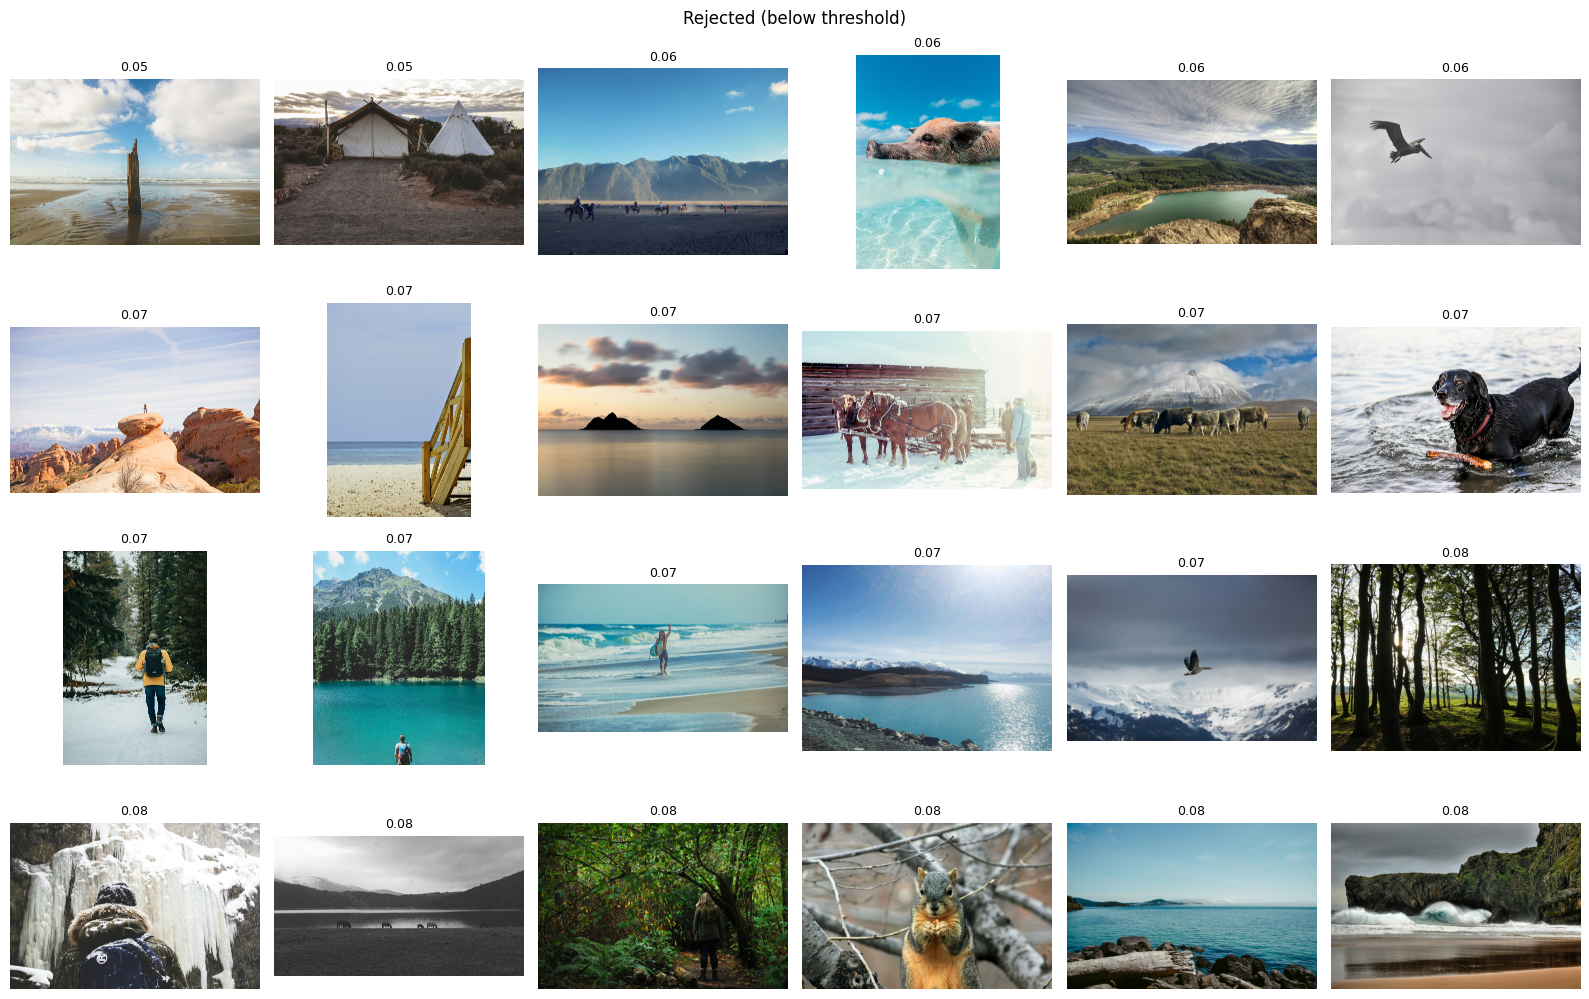

In [8]:
tau = 0.30  # جرّبه 0.28–0.35
rej = df_l14[df_l14["score"] < tau].sort_values("score").head(24)

def show_grid(df, title):
    n = len(df); cols = 6; rows = (n+cols-1)//cols
    plt.figure(figsize=(16, rows*2.6))
    for i, r in enumerate(df.itertuples(), 1):
        p = IMG_DIR / r.image_path
        try:
            img = Image.open(p).convert("RGB")
            ax = plt.subplot(rows, cols, i)
            ax.imshow(img); ax.axis("off"); ax.set_title(f"{r.score:.2f}", fontsize=9)
        except Exception as e:
            print("Bad:", p, e)
    plt.suptitle(title); plt.tight_layout(); plt.show()

show_grid(rej, "Rejected (below threshold)")


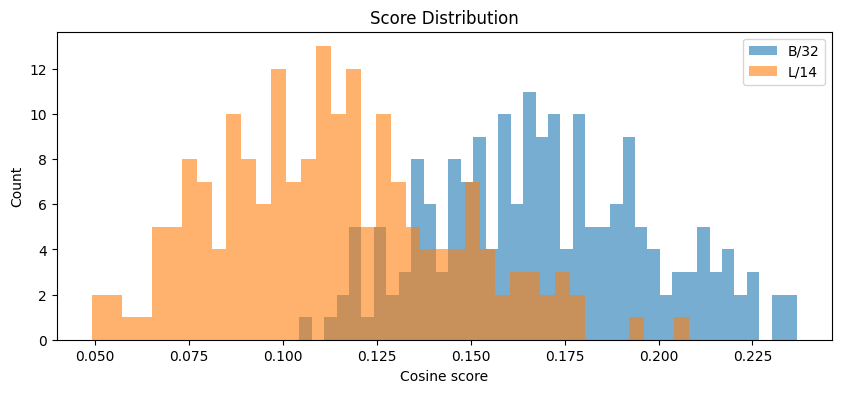

In [26]:
plt.figure(figsize=(10,4))
plt.hist(df_b32["score"], bins=40, alpha=0.6, label="B/32")
plt.hist(df_l14["score"], bins=40, alpha=0.6, label="L/14")
plt.xlabel("Cosine score"); plt.ylabel("Count"); plt.legend(); plt.title("Score Distribution")
plt.show()


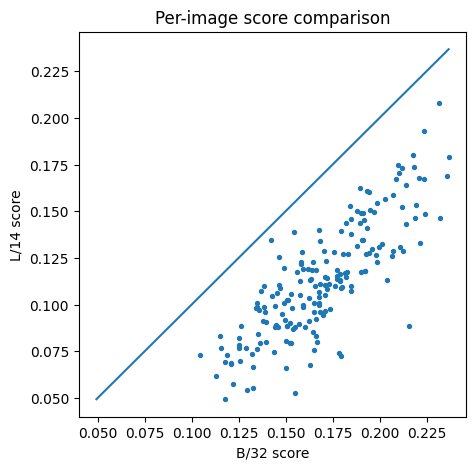

In [27]:
merged = df_b32.merge(df_l14, on="image_path", suffixes=("_B32","_L14"))
plt.figure(figsize=(5,5))
plt.scatter(merged["score_B32"], merged["score_L14"], s=8)
lims = [merged[["score_B32","score_L14"]].min().min(), merged[["score_B32","score_L14"]].max().max()]
plt.plot(lims, lims)
plt.xlabel("B/32 score"); plt.ylabel("L/14 score"); plt.title("Per-image score comparison")
plt.show()


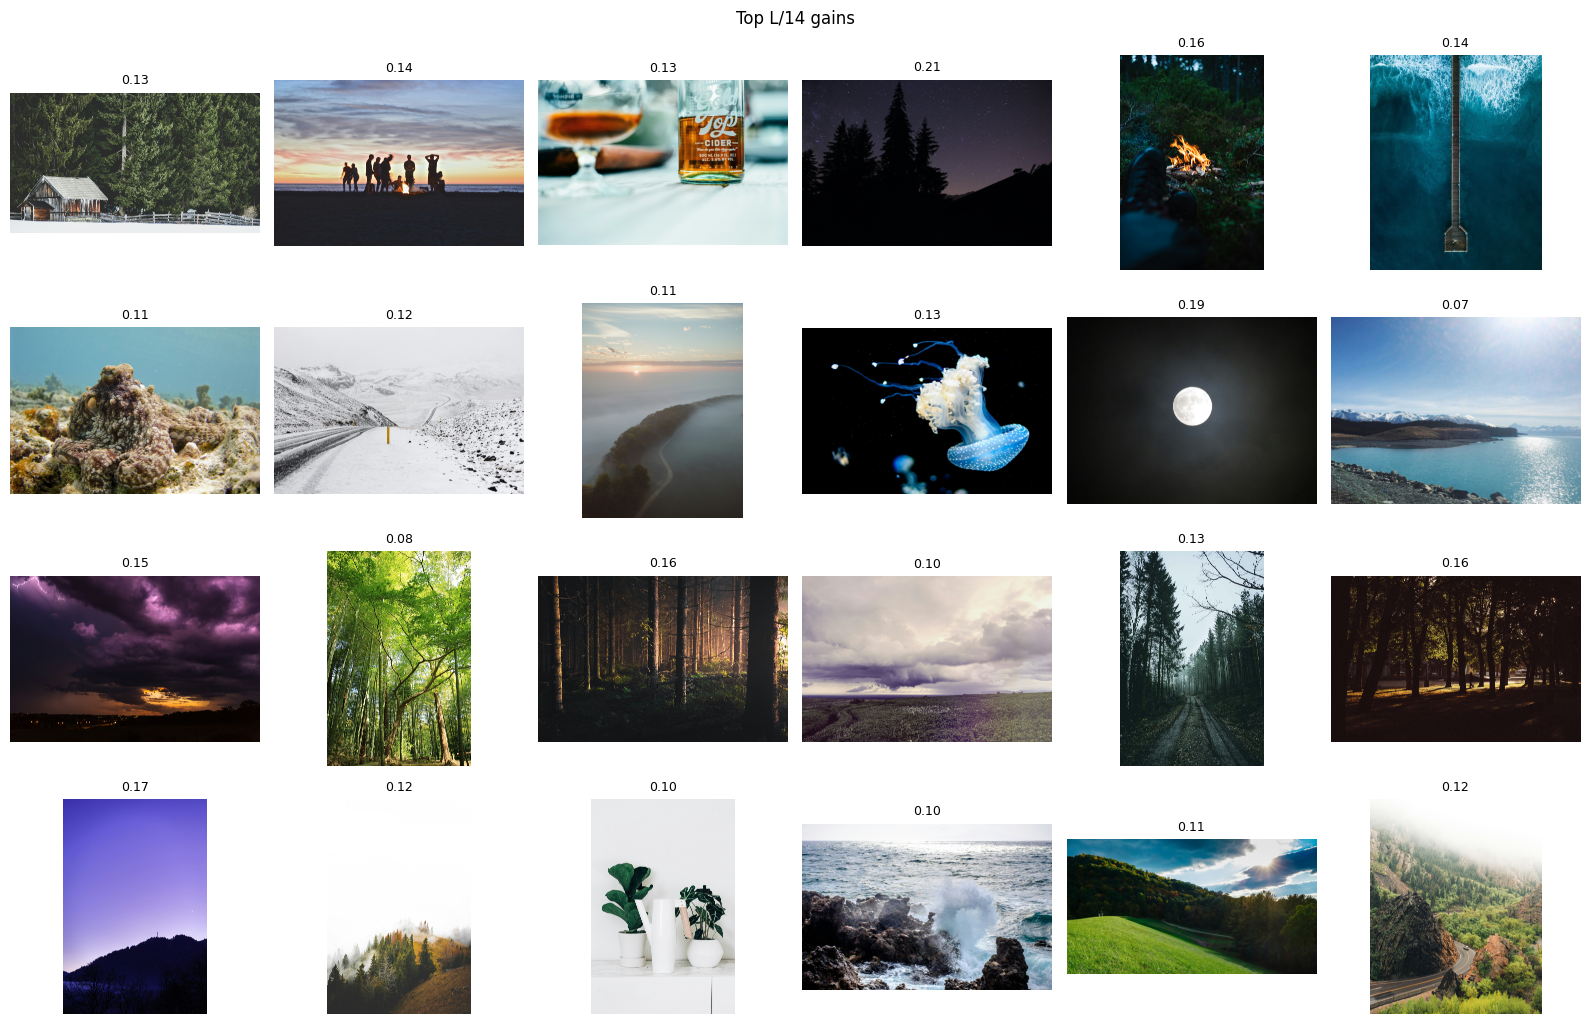

In [28]:
boost = merged.assign(delta=lambda d: d["score_L14"] - d["score_B32"]).sort_values("delta", ascending=False).head(24)
show_grid(boost[["image_path","score_L14"]].rename(columns={"score_L14":"score"}), "Top L/14 gains")

In [17]:
import open_clip, torch
device = "cuda" if torch.cuda.is_available() else "cpu"

# كان B/32:
# model, preprocess, _ = open_clip.create_model_and_transforms("ViT-B-32", pretrained="openai")

# إلى L/14 (224px):
model, preprocess, _ = open_clip.create_model_and_transforms("ViT-L-14", pretrained="openai")

# أو L/14@336:
# model, preprocess, _ = open_clip.create_model_and_transforms("ViT-L-14-336", pretrained="openai")

model = model.to(device).eval()


ModuleNotFoundError: No module named 'open_clip'